In [328]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [329]:
p1 = torch.distributions.Normal(torch.tensor(-3.),torch.tensor(1.))
p2 = torch.distributions.Normal(torch.tensor(3.),torch.tensor(1.))
def p(x):
    return torch.exp(p1.log_prob(x))*1/3+torch.exp(p2.log_prob(x))*2/3

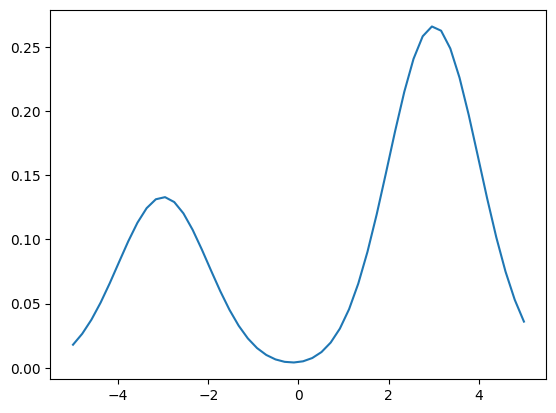

In [330]:
x = np.linspace(-5,5)
y = p(torch.tensor(x)).numpy()
plt.plot(x,y)

In [331]:
def Gaussian_log(x,mu,sigma):
    if not isinstance(x,torch.Tensor): x = torch.tensor(x).cuda()
    if not isinstance(mu,torch.Tensor): mu = torch.tensor(mu).cuda()
    if not isinstance(sigma,torch.Tensor): sigma= torch.tensor(sigma).cuda()
    dis = torch.distributions.Normal(mu,sigma)
    return dis.log_prob(x)

In [332]:
class Q1(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mu = nn.Parameter(torch.tensor(0.).cuda(),requires_grad=True)
        self.sigma = nn.Parameter(torch.tensor(1.).cuda(),requires_grad=True)
    def forward(self):
        N = 100000
        pick = torch.rand([N]).cuda()
        sample1 = p1.sample([N]).cuda()
        sample2 = p2.sample([N]).cuda()
        sample = sample1 * (pick<1/3).to(torch.float).cuda() + sample2 * (pick>1/3).to(torch.float).cuda()
        # dis = torch.distributions.Normal(torch.tensor(self.mu),torch.tensor(self.sigma))
        loss = torch.log(p(sample))-Gaussian_log(sample,self.mu,self.sigma)
        return loss.mean()
class Q2(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mu = nn.Parameter(torch.tensor(0.).cuda(),requires_grad=True)
        self.sigma = nn.Parameter(torch.tensor(1.).cuda(),requires_grad=True)
        self.prior = torch.distributions.Normal(torch.tensor(0.),torch.tensor(1.))
    def forward(self):
        N = 100000
        sample = self.prior.sample([N]).cuda()
        sample = self.sigma * sample + self.mu
        # dis = torch.distributions.Normal(torch.tensor(self.mu),torch.tensor(self.sigma))
        loss = -torch.log(p(sample))+Gaussian_log(sample,self.mu,self.sigma)
        return loss.mean()

In [333]:
from tqdm import tqdm
def train(q:Q2|Q1,optim,epochs=10000):
    with tqdm(range(epochs)) as bar:
        for epoch in bar:
            optim.zero_grad()
            loss = q()
            loss.backward()
            optim.step()
            if epoch % 10 == 0:
                bar.set_description('Epoch {},loss {:.6f}'.format(epoch+1,loss.item()))


In [334]:
from torch.optim import SGD
q1 = Q1().cuda()
opt1 = SGD(q1.parameters(),lr=0.01)
train(q1,opt1)

Epoch 11,loss 1.555749:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 9991,loss 0.468482: 100%|██████████| 10000/10000 [00:39<00:00, 250.88it/s]


In [338]:
q2 = Q2().cuda()
opt2 = SGD(q2.parameters(),lr=0.1)
train(q2,opt2)

Epoch 9991,loss 0.402501: 100%|██████████| 10000/10000 [00:25<00:00, 388.04it/s]


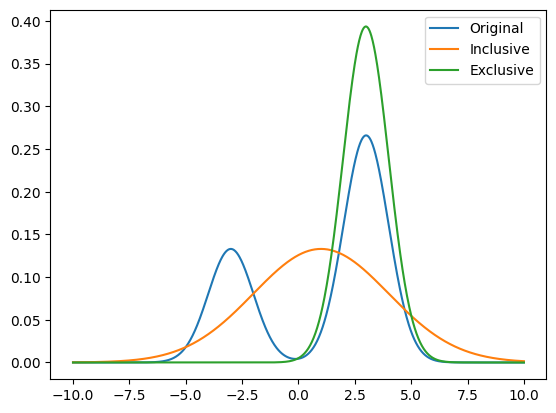

In [339]:
x = np.linspace(-10,10,1000)
y = p(torch.tensor(x)).numpy()
plt.plot(x,y,label='Original')
prior1 = torch.distributions.Normal(q1.mu,q1.sigma)
prior2 = torch.distributions.Normal(q2.mu,q2.sigma)
plt.plot(x,torch.exp(prior1.log_prob(torch.tensor(x).cuda())).cpu().detach().numpy(),label='Inclusive')
plt.plot(x,torch.exp(prior2.log_prob(torch.tensor(x).cuda())).cpu().detach().numpy(),label='Exclusive')
plt.legend()
plt.show()

In [340]:
print(q1.mu)
print(q1.sigma)
print(q2.mu)
print(q2.sigma)

Parameter containing:
tensor(0.9999, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(2.9999, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(2.9902, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(1.0138, device='cuda:0', requires_grad=True)


loss: 0.462940

- Parameter containing:
- tensor(1.0002, device='cuda:0', requires_grad=True)
- Parameter containing:
- tensor(3.0002, device='cuda:0', requires_grad=True)


loss: 0.402534

- Parameter containing:
- tensor(2.9910, device='cuda:0', requires_grad=True)
- Parameter containing:
- tensor(1.0160, device='cuda:0', requires_grad=True)
